# Running experiments

In this notebook we perform model selection and hyperparameter search for the segmentation model. The ultimate goal of this survey is to keep track of already explored configurations and how they perform, in order to select the best configuration for deployment later.

We use MLflow model tracking for such a purpose.

## Prepare notebook

We now set the current working directory, and load parameters from a configuration file.

In [1]:
import os

def set_directory(using_colab):
  """
  Set main directory to be just one level before the
  src and notebooks directories. It handles this differently depending whether
  we are in colab or local. If we are in colab we also mount the drive
  """

  if using_colab:

      if os.getcwd() == '/content':  # Starting folder by default

        # Mount drive if run function for the first time
        from google.colab import drive
        drive.mount('/content/drive')

      # Change dir to where project is located
      os.chdir(f"/content/drive/MyDrive/CoVision/segmentation")
  else:
    if 'models_seg' in os.listdir(os.getcwd()) or 'models_cla' in os.listdir(os.getcwd()): # Already in desired location
      pass
    else:
      os.chdir('../')  # Go back one level (from notebooks_seg to segmentation or classification folder)

  cwd = os.getcwd()
  print(f'Current working directory: {cwd}\n')

  return cwd

In [2]:
import sys
import os
import yaml
import argparse

# Check whether we are in colab or local
using_colab = True if 'google.colab' in sys.modules else False
# Set current working directory to be one level above the src folder
cwd = set_directory(using_colab)
# Read arguments from dict and store them as Namespace
if 'config_seg.yaml' in os.listdir(cwd):
  with open('config_seg.yaml', 'r') as f:
      args = argparse.Namespace(**yaml.safe_load(f))

  # Update directories
  for k in ['data_dir', 'save_path']:
    args.data_args[k] = os.path.join(cwd, args.data_args[k])
  # Split configuration file
  data_args = argparse.Namespace(**args.data_args)
  transformation_args = argparse.Namespace(**args.transformation_args)
  evaluation_args = argparse.Namespace(**args.evaluation_args)

# Add src folder and one level above to PYTHONPATH
sys.path.insert(0, 'src_seg/')
sys.path.insert(0, './../')

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

Current working directory: /home/guybrush/tomaco/covision/segmentation



## Setup server and define experiment

In [3]:
if using_colab:
  os.system("pip3 install pyngrok")  # Create remote tunnel using ngrok.com to allow local port access
  os.system("pip3 install mlflow")

import mlflow
from pathlib import Path

from utils.mlflow_utils import initiate_mlflow_server, create_mlflow_experiment

if 'models_seg' in os.listdir(os.getcwd()):
  os.chdir('models_seg')

In [4]:
# Initiate mlflow sever to default location http://127.0.0.1:5000
initiate_mlflow_server(using_colab)

# Experiment name
experiment_name = "MaskRCNN_ResNet50_Full_Aconag"
# Experiment description that will appear in the UI
experiment_description = (
    "This is the kit and membrane segmentation project.\n"
    "This experiment uses a MaskRCNN with ResNet50 backbone architecture.\n"
    "This experiment uses the full aconag trainset for trainning."
)
# Searchable tags that define characteristics of the different runs inside this experiment.
experiment_tags = {
    "project_name": "kit_membrane_segmentation",
    "architecture": "maskrcnn_resnet50",
    "data": "full_aconag",
    "mlflow.note.content": experiment_description,
}

# Create experiment
experiment_id = create_mlflow_experiment(experiment_name, tags=experiment_tags)

# Set experiment
experiment = mlflow.set_experiment(experiment_name=experiment_name)

[2024-06-09 19:20:50 +0200] [4548] [INFO] Starting gunicorn 21.2.0
[2024-06-09 19:20:50 +0200] [4548] [INFO] Listening at: http://127.0.0.1:5000 (4548)
[2024-06-09 19:20:50 +0200] [4548] [INFO] Using worker: sync
[2024-06-09 19:20:50 +0200] [4549] [INFO] Booting worker with pid: 4549
[2024-06-09 19:20:50 +0200] [4550] [INFO] Booting worker with pid: 4550
[2024-06-09 19:20:50 +0200] [4551] [INFO] Booting worker with pid: 4551
[2024-06-09 19:20:50 +0200] [4552] [INFO] Booting worker with pid: 4552


RESOURCE_ALREADY_EXISTS: Experiment 'MaskRCNN_ResNet50_Full_Aconag' already exists.


## Train, evaluate and MLflow run

we now train a model with a specific dataset and set of hyperparameters, evaluate it on a validation set and log the relevant parameters and characteristics using MLflow

In [5]:
from model_train_seg import TrainerSegmentation
from model_evaluate_seg import EvalSegmentation
from utils_seg.visualization import plot_metrics

In [13]:
# Parameters and hyperparameters
parameters = {
    'kit_id': ['aconag'],
    'val_set': 'val',
    'shots': [None],
    'seed': 42,
    'batch_size': 4,
    'num_workers': 2,
    'hidden_size': 512,
    'lr': "1e-5",
    'scheduler_step': 10,
    'scheduler_gamma': 2,
    'epochs': 30
}

In [14]:
# Train
trainer = TrainerSegmentation(args, parameters, do_validation=True)
trainer.train(save_state_bool=False)

Using cuda device
Random seed set as 42
Loading data...
Loaded 25 image and mask paths for aconag kit(s) in train data mode
Loaded 7 image and mask paths for aconag kit(s) in val data mode


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: lr 1e-05 -> 2e-05


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: lr 2e-05 -> 4e-05


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30: lr 4e-05 -> 8e-05


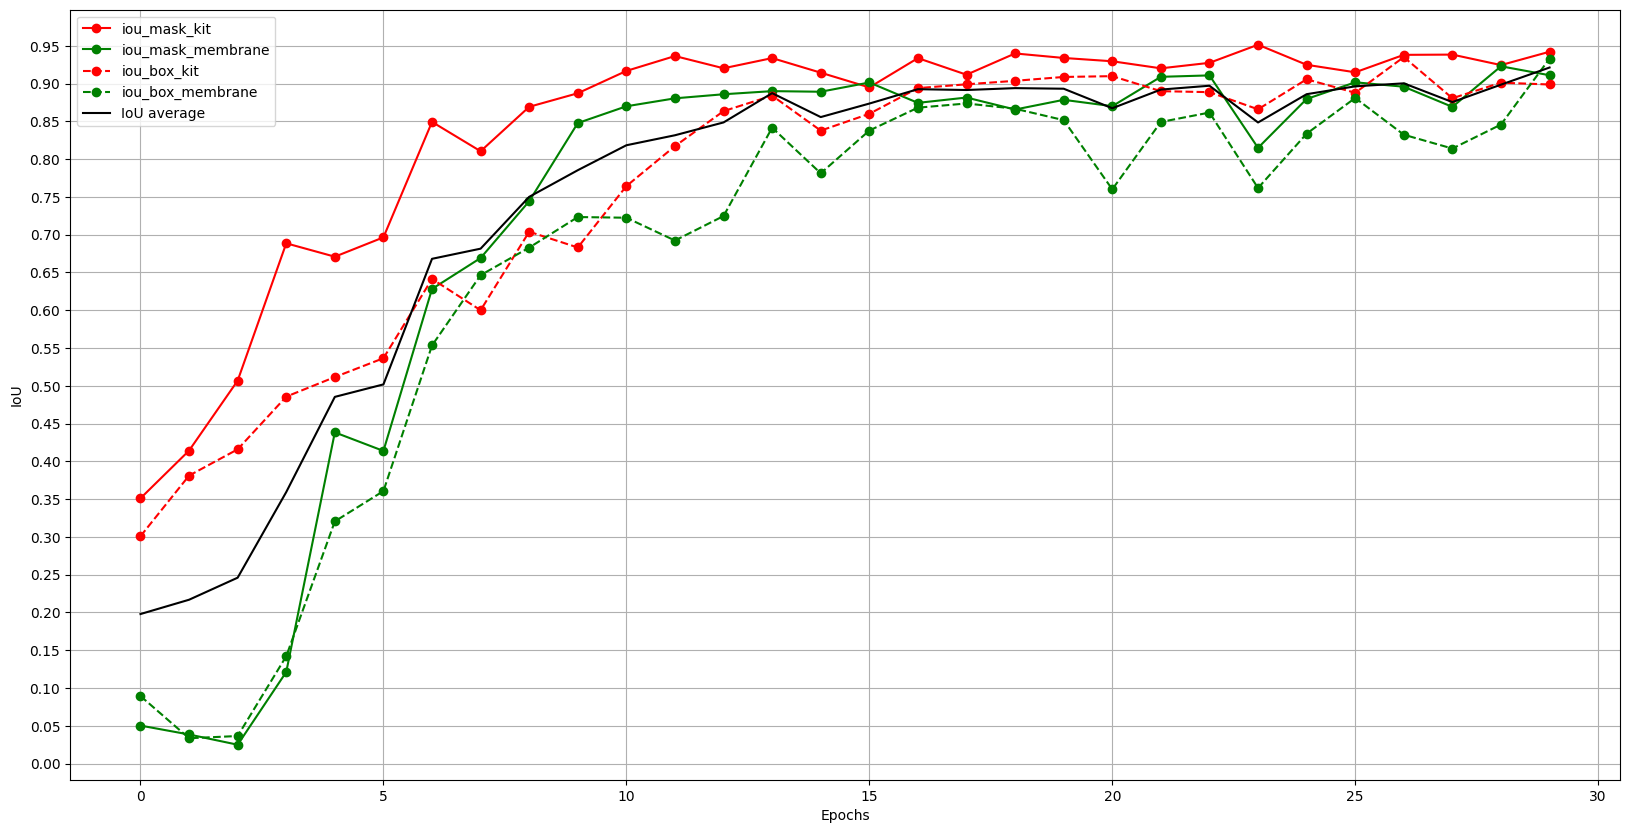

In [15]:
# Plot metrics
metrics_train_df, metrics_val_df = trainer.get_metrics()
plot_metrics(metrics_val_df)

In [16]:
# Evaluate best model on trainingset to get accuracy
tester = EvalSegmentation(args, model=trainer.best_model, n_batches=4, n_workers=2, device=None)
metrics_train_df = tester.evaluate(kit_id=trainer.get_parameters['kit_id'], data_mode='train')
metrics_val_df = tester.evaluate(kit_id=trainer.get_parameters['kit_id'], data_mode='val')

Loaded 25 image and mask paths for aconag kit(s) in train data mode


  0%|          | 0/7 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.996005
scores_membrane       0.986214
iou_masks_kit         0.948702
iou_masks_membrane    0.913745
iou_boxes_kit         0.901872
iou_boxes_membrane    0.894426
dtype: float64
iou_mean: 0.9147
Loaded 7 image and mask paths for aconag kit(s) in val data mode


  0%|          | 0/2 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.996120
scores_membrane       0.985522
iou_masks_kit         0.941623
iou_masks_membrane    0.911428
iou_boxes_kit         0.897610
iou_boxes_membrane    0.932240
dtype: float64
iou_mean: 0.9207


In [17]:
# Start MLflow run
with mlflow.start_run() as run:

    # Log hyperparameters
    mlflow.log_params(trainer.get_parameters)
    mlflow.log_params(trainer.args.transformation_args)
    mlflow.log_params({'n_trainset': len(metrics_train_df),
                       'n_valset': len(metrics_val_df)})

    # Log metrics
    train_means = metrics_train_df.mean().to_dict()
    train_iou_mean = float(metrics_train_df.iloc[:, 2:].mean().mean())
    val_means = metrics_val_df.mean().to_dict()
    val_iou_mean = float(metrics_val_df.iloc[:, 2:].mean().mean())

    for k, v in train_means.items():
      mlflow.log_metric('train_' + k, v)
    for k, v in val_means.items():
      mlflow.log_metric('val_' + k, v)
    mlflow.log_metric("train_best_iou_mean", train_iou_mean)
    mlflow.log_metric("val_best_iou_mean", val_iou_mean)
    mlflow.log_metric("epoch_of_best_iou_mean", trainer.best_epoch)

    # Log model
    mlflow.pytorch.log_model(pytorch_model=trainer.best_model, artifact_path='model')

2024/06/09 17:06:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/06/09 17:06:11 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.18.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.18.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Evaluate on unseen data

When obtained the best model according to the validation set, we evaluate the model on unseen data such as test sets or other kits. We store the relevant parameters, metrics and figures as artifacts inside the `mlruns` folder.

The best model is also registered in the MLflow model registry to specify that such a model finished with the deployment stage. Currently, this registration mus be done manually using the MLflow ui.

In [7]:
from model_evaluate_seg import EvalSegmentation

In [5]:
# Load model from run_id
run_id = "2d2f63e38dd74a41bdb8fa6d18aaab34"# run.info.run_id
model = mlflow.pytorch.load_model(model_uri=f"runs:/{run_id}/model", map_location='cpu')

# Path to save evaluation artifacts
save_path = os.path.join(cwd, f'models_seg/mlruns/{experiment_id}/{run_id}/artifacts/model_evaluation')

2024/06/09 19:23:57 WARNING mlflow.pytorch: Stored model version '2.3.0+cu121' does not match installed PyTorch version '2.3.1'


In [8]:
tester = EvalSegmentation(args, model=model, device=None)

In [9]:
metrics_test_df = tester.evaluate(kit_id=['aconag'], data_mode='test', save_bool=True, save_path=save_path)

Loaded 8 image and mask paths for aconag kit(s) in test data mode


  0%|          | 0/4 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.980897
scores_membrane       0.974186
iou_masks_kit         0.934517
iou_masks_membrane    0.926212
iou_boxes_kit         0.888164
iou_boxes_membrane    0.907736
dtype: float64
iou_mean: 0.9142


In [11]:
_ = tester.evaluate(kit_id=['deepblueag', 'aconag'], data_mode='all', save_bool=True, save_path=save_path)

Loaded 80 image and mask paths for deepblueag-aconag kit(s) in all data mode


  0%|          | 0/40 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.977995
scores_membrane       0.989511
iou_masks_kit         0.932372
iou_masks_membrane    0.905375
iou_boxes_kit         0.903944
iou_boxes_membrane    0.903174
dtype: float64
iou_mean: 0.9112


In [12]:
_ = tester.evaluate(kit_id=['deepblueag', 'aconag'], data_mode='test', save_bool=True, save_path=save_path)

Loaded 16 image and mask paths for deepblueag-aconag kit(s) in test data mode


  0%|          | 0/8 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.982526
scores_membrane       0.981991
iou_masks_kit         0.937300
iou_masks_membrane    0.916565
iou_boxes_kit         0.910387
iou_boxes_membrane    0.901745
dtype: float64
iou_mean: 0.9165
